<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.0.0+cu118


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [6]:
# 1. Get data
import requests
from zipfile import ZipFile
from pathlib import Path
import os

data_path = Path("data")
images_path= data_path / "pizza_steak_sushi"

images_path.mkdir(parents=True, exist_ok=True)

with open (data_path/"pizza_steak_sushi.zip","wb") as f:
    requete=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(requete.content)

with ZipFile(data_path/"pizza_steak_sushi.zip","r") as f:
    f.extractall(images_path)


os.remove(data_path/"pizza_steak_sushi.zip")


In [7]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [8]:
# Setup train and testing paths
train_path=images_path/"train"
test_path=images_path/"test"

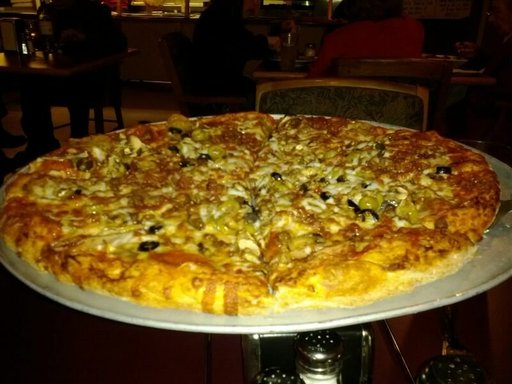

In [13]:
# Visualize an image
from PIL import Image
import torch
import matplotlib.pyplot as plt

liste_paths=list(images_path.glob("*/*/*.jpg"))

image_une=Image.open(liste_paths[0])
image_une

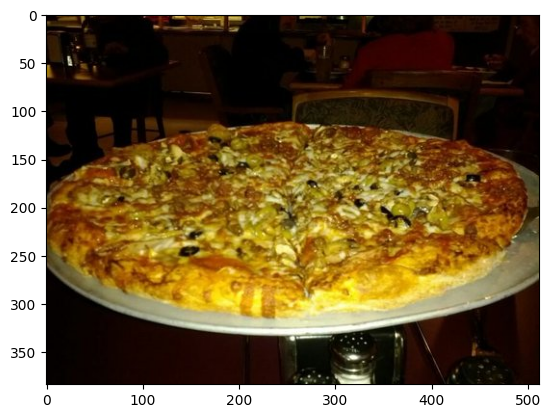

In [14]:
# Do the image visualization with matplotlib
plt.figure()
plt.imshow(image_une)


We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [16]:
# 3.1 Transforming data with torchvision.transforms
from torch.utils.data import DataLoader
from torchvision import transforms

In [17]:
# Write transform for turning images into tensors
transformer=transforms.Compose([
                        transforms.Resize((64,64)),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.ToTensor()])

<Figure size 640x480 with 0 Axes>

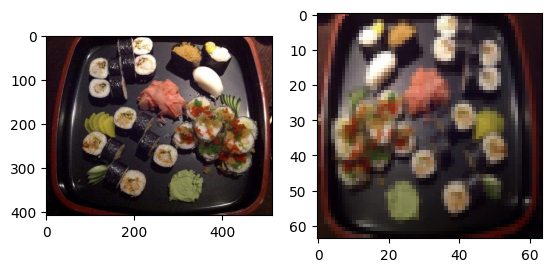

<Figure size 640x480 with 0 Axes>

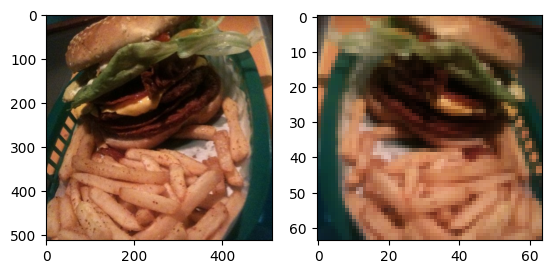

<Figure size 640x480 with 0 Axes>

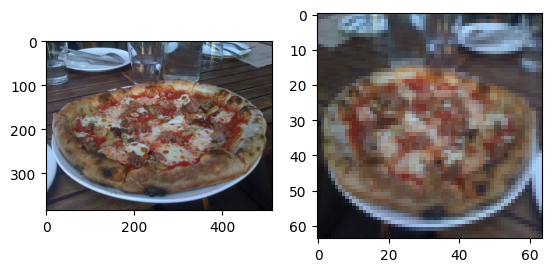

In [29]:
# Write a function to plot transformed images
def plot_transformed_image(images_path,seed,n,transformer):
    import random
    import numpy as np
    random.seed(seed)
    liste_path=list(images_path.glob("*/*/*.jpg"))
    liste_de_n=random.sample(liste_path,k=n)

    for path in liste_de_n:
        image=Image.open(path)
        image_transformed=transformer(image)
        plt.figure()
        a,b=plt.subplots(nrows=1,ncols=2)
        b[0].imshow(image)
        b[1].imshow(image_transformed.permute(1,2,0))

plot_transformed_image(images_path=images_path,seed=42,n=3,transformer=transformer)

### Load image data using `ImageFolder`

In [34]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_path,
                                  transform=transformer,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_path,
                                  transform=transformer,
                                  target_transform=None)

In [31]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [32]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [35]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [40]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

train_dl = DataLoader(dataset=train_data,
                      batch_size=1,
                      shuffle=True,
                      num_workers=os.cpu_count())

test_dl=DataLoader(dataset=test_data,
                   batch_size=1,
                   shuffle=False,
                   num_workers=os.cpu_count())

In [41]:
# How many batches of images are in our data loaders?
len(train_dl), len(test_dl)

(225, 75)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [49]:
import torch
from torch import nn

class TinyVGG(nn.Module):
    def __init__(self,input,hidden,output): 
        super().__init__()

        self.block1= nn.Sequential(
            nn.Conv2d(in_channels=input,out_channels=hidden,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.block2= nn.Sequential(
            nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden*16*16,out_features=output)
        )

    def forward(self,x):
        return self.classifier(self.block2(self.block1(x)))

## 4. Create training and testing functions for `model_0`.

In [54]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (x,y) in enumerate(dataloader):
    # Send data to target device
    x=x.to(device)
    y=y.to(device)
    # 1. Forward pass
    pred = model(x)
    # 2. Calculate and accumulate loss
    loss=loss_fn(pred,y)
    train_loss += loss.item()

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_label=torch.argmax(torch.softmax(pred,dim=1),dim=1)
    train_acc += (y_label==y).sum().item()/len(pred)
    

  # Adjust metrics to get average loss and average accuracy per batch
  train_acc=train_acc / len(dataloader) 
  train_loss=train_loss / len(dataloader) 
  return train_acc, train_loss

In [44]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (x,y) in enumerate(dataloader):
      # Send data to target device
      x = x.to(device)
      y = y.to(device)

      # 1. Forward pass
      pred=model(x)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(pred,y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      label=torch.argmax(torch.softmax(pred,dim=1),dim=1)
      test_acc += (label == y).max().sum()/len(pred)
    
  # Adjust metrics to get average loss and accuracy per batch
  test_acc=test_acc / len(dataloader) 
  test_loss=test_loss / len(dataloader) 
  return test_acc, test_loss

In [45]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [55]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model=TinyVGG(input=3,
              hidden=10,
              output=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=0.001)

model_0_res = train(model=model,
                    train_dataloader=train_dl,
                    test_dataloader=test_dl,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=5)

 20%|██        | 1/5 [00:19<01:19, 19.81s/it]

Epoch: 1 | train_loss: 0.2933 | train_acc: 1.1181 | test_loss: 0.3200 | test_acc: 1.0965


 40%|████      | 2/5 [00:40<01:00, 20.16s/it]

Epoch: 2 | train_loss: 0.3156 | train_acc: 1.1029 | test_loss: 0.2533 | test_acc: 1.0998


 60%|██████    | 3/5 [01:00<00:40, 20.37s/it]

Epoch: 3 | train_loss: 0.2978 | train_acc: 1.0999 | test_loss: 0.3333 | test_acc: 1.0999


 80%|████████  | 4/5 [01:21<00:20, 20.31s/it]

Epoch: 4 | train_loss: 0.3244 | train_acc: 1.0990 | test_loss: 0.3333 | test_acc: 1.1002


100%|██████████| 5/5 [01:41<00:00, 20.37s/it]

Epoch: 5 | train_loss: 0.3333 | train_acc: 1.1026 | test_loss: 0.3333 | test_acc: 1.1012


In [ ]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(#TODO, 
                             lr=0.001)

In [ ]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(#TODO, 
                             lr=0.001)

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [ ]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)


It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [ ]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

In [ ]:
# See how many images we have
walk_through_dir(image_path)

Excellent, we now have double the training and testing images... 

In [ ]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

In [ ]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

# Create datasets


# Create dataloaders


In [ ]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [66]:
import torchvision

model.eval()
with torch.inference_mode():
    image = torchvision.io.read_image("D:\Adam\Pytorch\exercises\pizza.jpg")
    transformer = transforms.Resize((64,64))
    image = transformer(image)

    batch = image.unsqueeze(0).float().to(device)
    pred = model(batch)

label = torch.argmax(torch.softmax(pred,dim=1),dim=1)

class_names[label]

C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


'sushi'